In [3]:
!pip install asteval attr attrdict

In [4]:
'''
Demos written and developed by: Andrew E. Oriani 2020 EMAIL: oriani@uchicago.edu

'''
from PyInventor import *
import numpy as np
from numpy import pi, cos, sin, sqrt, log
import math
import glob
import time
import datetime

#Import plotting libraries for later
import matplotlib
from matplotlib import pyplot as plt

from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm 
from matplotlib.ticker import MaxNLocator

import pandas as pd

import pyEPR
from pyEPR import ansys as HFSS
from pyEPR.core_distributed_analysis import CalcObject

import scipy
from scipy import constants as const

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity
import os
import re as regex

# Field integrals code
import sys
sys.path.append('../python/src')
import field_integrals as fint

# Eigenmode:

<img src="Pictures/Cavity Eigenmode.png" alt="drawing" width="400">

Determines first 5 eigenmode frequencies in absence of any qubit. This demonstration also calculates S_e and S_m (electric and magnetic field participation of the cavity modes) for the first (TE_101) mode.

In [224]:
'''
HFSS eigenmode simulation Creation:

This sets up a standard eigenmode simulation without the qubit, just the bare cavity created above. It calculates
the mode frequencies, loss (with boundary impedances set) and the electric and magnetic surface participation 
ratios (S_e, S_m)

'''
# Project and HFSS design names for the bare waveguide model
dd = datetime.datetime.today().strftime('%y%m%d')
# dd = '230418'
solution_type = 'eigenmode'

# solution_type = 'driven_modal'
overwrite = False
ref_name = 'gwave_detection_mago'
# ref_name = 'planar_pads_l_coupled_three_cavities_degen'
project_name=f'{ref_name}'
design_name=f'two_sphere_simple'


#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\HFSS\\'+project_name+'.aedt'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.save(full_path)
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        
        # Setup a driven modal design type
        if solution_type == 'driven_modal':
            EM_design=project.new_dm_design(design_name)
        elif solution_type == 'eigenmode':
            EM_design=project.new_em_design(design_name)
        else:
            raise ValueError(f'Solution type ({solution_type}) not recognized.')
    else:
        EM_design=project.get_design(design_name)
        
else:
    if solution_type == 'driven_modal':
        EM_design=project.new_dm_design(design_name)
    elif solution_type == 'eigenmode':
        EM_design=project.new_em_design(design_name)
    else:
        raise ValueError(f'Solution type ({solution_type}) not recognized.')
        
EM_design.make_active()
model=HFSS.HfssModeler(EM_design)

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        EM_design=project.new_em_design(design_name)
    else:
        EM_design=project.get_design(design_name)
        
else:
    EM_design=project.new_em_design(design_name)
        
EM_design.make_active()
model=HFSS.HfssModeler(EM_design)

project_name: gwave_detection_mago
path: Z:\tcav\ipynbs\HFSS\gwave_detection_mago.aedt
project_name: gwave_detection_mago
path: Z:\tcav\ipynbs\HFSS\gwave_detection_mago.aedt


### Eigenmode simulation and $L_J$ sweep

In [ ]:
#setup the analysis and optimetrics
opti_setup = HFSS.Optimetrics(EM_design)

#set the optimetrics step size and number of steps
step = .2
num_step = 1

sweep_type = 'decade'

#create optimetrics setup
# swp_var = L_jj
# swp_var_unit = 'nH'
# swp_var = xoffset
# swp_var_unit = 'mm'
start = 0.1e-9
stop = 100e-9
dstep = 3
num_step = int(np.round((stop-start)/dstep) + 1)
num_step = 3

tstamp = datetime.datetime.today().strftime('%y%m%d_%H_%M_%S')
if sweep_type == 'decade':
    opti_setup.create_setup(variable=swp_var,
                        swp_type= 'decade',
                        swp_params=('%.2f%s'%(start, swp_var_unit),
                                    '%.2f%s'%(stop, swp_var_unit), 
                                    str(num_step)),
                        name=f'{swp_var}_Sweep_{tstamp}',
                        save_fields=True,
                        solve_with_copied_mesh_only=False,
                        copy_mesh=False)
elif sweep_type == 'linear':
    opti_setup.create_setup(variable=swp_var,
                        swp_type= 'linear_step',
                        swp_params=('%.2f%s'%(start, swp_var_unit),
                                    '%.2f%s'%(stop, swp_var_unit), 
                                    '%.2f%s' \
                                    % (((stop - start) / num_step),
                                       swp_var_unit)),
                        name=f'{swp_var}_Sweep_{tstamp}',
                        save_fields=True,
                        solve_with_copied_mesh_only=False,
                        copy_mesh=False)
else:
    raise ValueError(f'sweep_type ({sweep_type}) unrecognized.')
            
#solve it
opti_setup.solve_setup(f'{swp_var}_Sweep_{tstamp}')

#save project
project.save()

In [176]:
def set_axes_fonts(ax, fsize):
    """
    Set axes font sizes because it should be abstracted away
    """
    for tick in ax.get_xticklabels():
        tick.set_fontsize(fsize)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(fsize)

def set_xaxis_rot(ax, angle=45):
    """
    Rotate the x-axis labels
    """
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

def set_leg_outside(ax, fsize):
    """
    Sets the legend location outside
    """
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    hdls, legs = ax.get_legend_handles_labels()
    leg = ax.legend(hdls, legs, loc='center left', bbox_to_anchor=(1, 0.5), \
                    fontsize=fsize, framealpha=0.)

    return leg

In [208]:
def plot_2d_cmap(x, y, z, fname,                                                
                 xstr='', ystr='',                                              
                 tstr='', cbar_str='',                                          
                 cmap=cm.viridis,
                 xyscales={'x' : 'linear', 'y': 'linear'},
                 interp_zeros=False,
                interp_std_dev=10,
                image_rot_angle=0,
                xrot_angle=None,
                norm_type='linear',
                zref=None, 
                fsize=30,
                tsize=36):
    """                                                                         
    Plot 2D colormap data such that                                             
                                                                                
         -----------------------                                                
         |                     |                                                
         |                     |                                                
    y    |          z          |                                                
         |                     |                                                
         |                     |                                                
         -----------------------                                                
                                                                                
                    x                                                           
                                                                                
    Parameters:                                                                 
    ----------                                                                  
                                                                                
    x, y:       independent variables                                           
    z:          resulting data, z = z(x, y)                                     
    fname:      output figure filename, relative path with file extension       
    xstr:       x-axis label                                                    
    ystr:       y-axis label                                                    
    tstr:       title label                                                     
    cbar_str:   lable for color bar                                             
    cmap:       colormap to use on the 2D figure output                         
                                                                                
    """
    # Interpolate the data
    if interp_zeros:
        hot_pixels, z = fix_outlier_pixels(z, tolerance=interp_std_dev)
    
    # Setup the color map, normalizations, etc
    if norm_type == 'linear':
        norm = mpl.colors.Normalize(z.min(), z.max())
    elif norm_type == 'log':
        if zref:
            norm = mpl.colors.LogNorm(min(zref), max(zref))
        else:
            norm = mpl.colors.Normalize(min(zref), max(zref))    
    elif (norm_type == 'ref') and zref:
        norm = mpl.colors.Normalize(min(zref), max(zref))
    else:
        raise ValueError(f'norm_type ({norm_type}) not recognized')                                         
                                                                                
    # Setup the figure and axes                                                 
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
    
    # Set the scale bar and levels
    if (norm_type == 'ref') and zref:
        levels = MaxNLocator(nbins=20).tick_values(min(zref), max(zref))
    else:
        levels = MaxNLocator(nbins=20).tick_values(z.min(), z.max())
    if image_rot_angle:
        z = scipy.ndimage.rotate(z, image_rot_angle, reshape=True)
    #plt1 = ax.imshow(z, cmap=cmap, norm=norm)
    plt1 = ax.pcolormesh(x, y, z, cmap=cmap, norm=norm)
    ax.set_xlabel(xstr, fontsize=fsize)                                         
    ax.set_ylabel(ystr, fontsize=fsize)                                         
    ax.set_title(tstr, fontsize=tsize)
    
    # Rotate the xlabels. Set both x and y labels to headers[1:]
    ax.set_xscale(xyscales['x'])
    ax.set_yscale(xyscales['y'])
    if xrot_angle is not None:
        set_xaxis_rot(ax, xrot_angle)
                                                                                
    # Set the axis tick labels to a reasonable size                             
    set_axes_fonts(ax, fsize)                                                   
                                                                                
    # Set the color bar, offset the title slightly from top                     
    cbar = fig.colorbar(plt1, ax=ax)                                            
    cbar.ax.set_title(cbar_str, fontsize=fsize, y=1.025)                        
    cbar.ax.tick_params(labelsize=fsize)                                        
                                                                                
    # Write the results to file
    print(f'Writing {fname} ...')
    fig.savefig(fname, format='pdf', transparent=True)                  

## Read the electric field data to perform the integrals

In [225]:
# Setup the pyEPR project
Nmodes = 2
pinfo = pyEPR.ProjectInfo(HFSS_path+'\\HFSS',  
                         project_name,
                         design_name)
# Setup for EPR anaylsis
eprh = pyEPR.DistributedAnalysis(pinfo)

# Read off the inductances and x-offsets from the variations
variations = eprh.solutions.list_variations()
Ljstrs = []; Lj_vals = []
vstr = 'r_a'; vunits = 'mm'
#xoffstrs = []; xoff_vals = []
for v in variations:
    Ljstrs.append(regex.findall(f'{vstr}=\'(.*?{vunits})', v)[0].replace('.', 'p'))
    Lj_vals.append(float(regex.findall(f'{vstr}=\'(.*?){vunits}', v)[0]))
 #   xoffstrs.append(regex.findall('x_offset=\'(.*?mm)', v)[0].replace('.', 'p'))
 #   xoff_vals.append(regex.findall('x_offset=\'(.*?mm)', v)[0])

INFO 11:21AM [connect]: Connecting to Ansys Desktop API...
INFO 11:21AM [load_ansys_project]: 	File path to HFSS project found.
INFO 11:21AM [load_ansys_project]: 	Opened Ansys App
INFO 11:21AM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 11:21AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    Z:/tcav/ipynbs/HFSS/
	Project:   gwave_detection_mago
INFO 11:21AM [connect]: 	Opened active design
	Design:    two_sphere_simple [Solution type: Eigenmode]
INFO 11:21AM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 11:21AM [connect]: 	Connection to Ansys established successfully. 😀 



Design "two_sphere_simple" info:
	# eigenmodes    8
	# variations    19


In [226]:
Lj_sort_idxs = np.argsort(Lj_vals)
Lj_vals = np.unique(np.asarray(Lj_vals)[Lj_sort_idxs])
Ljstrs = np.asarray(Ljstrs)[Lj_sort_idxs]

In [227]:
Lj_sort_idxs

array([ 0,  1,  2,  3,  4, 11, 12, 13, 14,  5, 15, 16, 17, 18,  6,  7,  8,
        9, 10], dtype=int64)

In [228]:
Lj_vals

array([14.5 , 14.6 , 14.7 , 14.8 , 14.9 , 14.92, 14.94, 14.96, 14.98,
       15.  , 15.02, 15.04, 15.06, 15.08, 15.1 , 15.2 , 15.3 , 15.4 ,
       15.5 ])

In [229]:
Ljstrs

array(['14p5mm', '14p6mm', '14p699999999999999mm', '14p800000000000001mm',
       '14p9mm', '14p92mm', '14p94mm', '14p960000000000001mm', '14p98mm',
       '15mm', '15p02mm', '15p039999999999999mm', '15p06mm', '15p08mm',
       '15p1mm', '15p199999999999999mm', '15p300000000000001mm', '15p4mm',
       '15p5mm'], dtype='<U20')

In [230]:
vstrs = [f'{vstr}{l}' for l in Ljstrs]

In [231]:
vstrs

['r_a14p5mm',
 'r_a14p6mm',
 'r_a14p699999999999999mm',
 'r_a14p800000000000001mm',
 'r_a14p9mm',
 'r_a14p92mm',
 'r_a14p94mm',
 'r_a14p960000000000001mm',
 'r_a14p98mm',
 'r_a15mm',
 'r_a15p02mm',
 'r_a15p039999999999999mm',
 'r_a15p06mm',
 'r_a15p08mm',
 'r_a15p1mm',
 'r_a15p199999999999999mm',
 'r_a15p300000000000001mm',
 'r_a15p4mm',
 'r_a15p5mm']

In [232]:
vars_sorted = np.asarray(eprh.variations)[Lj_sort_idxs]

In [233]:
[eprh._get_lv(v) for v in vars_sorted]

[['l_cpl:=', '10mm', 'r_a:=', '14.5mm', 'r_b:=', '15mm', 'r_cpl:=', '3mm'],
 ['l_cpl:=', '10mm', 'r_a:=', '14.6mm', 'r_b:=', '15mm', 'r_cpl:=', '3mm'],
 ['l_cpl:=',
  '10mm',
  'r_a:=',
  '14.699999999999999mm',
  'r_b:=',
  '15mm',
  'r_cpl:=',
  '3mm'],
 ['l_cpl:=',
  '10mm',
  'r_a:=',
  '14.800000000000001mm',
  'r_b:=',
  '15mm',
  'r_cpl:=',
  '3mm'],
 ['l_cpl:=', '10mm', 'r_a:=', '14.9mm', 'r_b:=', '15mm', 'r_cpl:=', '3mm'],
 ['l_cpl:=', '10mm', 'r_a:=', '14.92mm', 'r_b:=', '15mm', 'r_cpl:=', '3mm'],
 ['l_cpl:=', '10mm', 'r_a:=', '14.94mm', 'r_b:=', '15mm', 'r_cpl:=', '3mm'],
 ['l_cpl:=',
  '10mm',
  'r_a:=',
  '14.960000000000001mm',
  'r_b:=',
  '15mm',
  'r_cpl:=',
  '3mm'],
 ['l_cpl:=', '10mm', 'r_a:=', '14.98mm', 'r_b:=', '15mm', 'r_cpl:=', '3mm'],
 ['l_cpl:=', '10mm', 'r_a:=', '15mm', 'r_b:=', '15mm', 'r_cpl:=', '3mm'],
 ['l_cpl:=', '10mm', 'r_a:=', '15.02mm', 'r_b:=', '15mm', 'r_cpl:=', '3mm'],
 ['l_cpl:=',
  '10mm',
  'r_a:=',
  '15.039999999999999mm',
  'r_b:=',
  '15mm

In [234]:
len(vars_sorted)

19

## Need to manually create Vector_E plot in GUI first
* TODO: Create a new field plot, then export the field data with ansys.py

In [235]:
# Build a string for each variation to label the output files
Nmodes = 2
for idx, v in enumerate(vars_sorted):
    # Set the variation
    eprh.set_variation(v)
    lv = eprh._get_lv(v)
    print(f'Variation: {vstrs[idx]}')
    for kp in range(Nmodes):
        # Set the solution to mode kp
        eprh.solutions.set_mode(kp+1)
        # time.sleep(0.5)
        print(f'Mode-{kp+1}')
        des = EM_design._design
        omod = des.GetModule('FieldsReporter')
        omod.ExportFieldPlot("Vector_E1", False, f"Z:\\tcav\\data\\efields_two_post_cpl_only_mode_{kp+1}_{vstrs[idx]}.aedtplt")
print('Finished writing field data to file.')

Variation: r_a14p5mm
Mode-1
Mode-2
Variation: r_a14p6mm
Mode-1
Mode-2
Variation: r_a14p699999999999999mm
Mode-1
Mode-2
Variation: r_a14p800000000000001mm
Mode-1
Mode-2
Variation: r_a14p9mm
Mode-1
Mode-2
Variation: r_a14p92mm
Mode-1
Mode-2
Variation: r_a14p94mm
Mode-1
Mode-2
Variation: r_a14p960000000000001mm
Mode-1
Mode-2
Variation: r_a14p98mm
Mode-1
Mode-2
Variation: r_a15mm
Mode-1
Mode-2
Variation: r_a15p02mm
Mode-1
Mode-2
Variation: r_a15p039999999999999mm
Mode-1
Mode-2
Variation: r_a15p06mm
Mode-1
Mode-2
Variation: r_a15p08mm
Mode-1
Mode-2
Variation: r_a15p1mm
Mode-1
Mode-2
Variation: r_a15p199999999999999mm
Mode-1
Mode-2
Variation: r_a15p300000000000001mm
Mode-1
Mode-2
Variation: r_a15p4mm
Mode-1
Mode-2
Variation: r_a15p5mm
Mode-1
Mode-2
Finished writing field data to file.


## Need to manually create Vector_H (90 degrees phase) plot in GUI first

In [236]:
# Build a string for each variation to label the output files
Nmodes = 2
for idx, v in enumerate(vars_sorted):
    # Set the variation
    eprh.set_variation(v)
    lv = eprh._get_lv(v)
    print(f'Variation: {vstrs[idx]}')
    for kp in range(Nmodes):
        # Set the solution to mode kp
        eprh.solutions.set_mode(kp+1)
        # time.sleep(0.5)
        print(f'Mode-{kp+1}')
        des = EM_design._design
        omod = des.GetModule('FieldsReporter')
        omod.ExportFieldPlot("Vector_H1", False, f"Z:\\tcav\\data\\hfields_two_post_cpl_only_mode_{kp+1}_{vstrs[idx]}.aedtplt")
print('Finished writing field data to file.')

Variation: r_a14p5mm
Mode-1
Mode-2
Variation: r_a14p6mm
Mode-1
Mode-2
Variation: r_a14p699999999999999mm
Mode-1
Mode-2
Variation: r_a14p800000000000001mm
Mode-1
Mode-2
Variation: r_a14p9mm
Mode-1
Mode-2
Variation: r_a14p92mm
Mode-1
Mode-2
Variation: r_a14p94mm
Mode-1
Mode-2
Variation: r_a14p960000000000001mm
Mode-1
Mode-2
Variation: r_a14p98mm
Mode-1
Mode-2
Variation: r_a15mm
Mode-1
Mode-2
Variation: r_a15p02mm
Mode-1
Mode-2
Variation: r_a15p039999999999999mm
Mode-1
Mode-2
Variation: r_a15p06mm
Mode-1
Mode-2
Variation: r_a15p08mm
Mode-1
Mode-2
Variation: r_a15p1mm
Mode-1
Mode-2
Variation: r_a15p199999999999999mm
Mode-1
Mode-2
Variation: r_a15p300000000000001mm
Mode-1
Mode-2
Variation: r_a15p4mm
Mode-1
Mode-2
Variation: r_a15p5mm
Mode-1
Mode-2
Finished writing field data to file.


In [237]:
from importlib import reload
reload(fint)

<module 'field_integrals' from 'Z:\\tcav\\ipynbs\\../python/src\\field_integrals.py'>

In [238]:
data_path = f'../data'
hfield_format = f'hfields_two_post_cpl_only_mode_%d_{vstr}%s.aedtplt'
efield_format = f'efields_two_post_cpl_only_mode_%d_{vstr}%s.aedtplt'
Nmodes = 2
myfields = fint.FieldIntegrals(# eprh,
                 Nmodes, data_path,
                 Lj_vals, np.array([0]*len(Lj_vals)),
                 Ljstrs,
                 hfield_format, efield_format,
                 jjstr=None, LJstr=None,
                 jj_area = None, debug=False,
                normalize_fields=True)

Integrals will use normalized fields.


In [239]:
Ljstrs

array(['14p5mm', '14p6mm', '14p699999999999999mm', '14p800000000000001mm',
       '14p9mm', '14p92mm', '14p94mm', '14p960000000000001mm', '14p98mm',
       '15mm', '15p02mm', '15p039999999999999mm', '15p06mm', '15p08mm',
       '15p1mm', '15p199999999999999mm', '15p300000000000001mm', '15p4mm',
       '15p5mm'], dtype='<U20')

In [240]:
AE, AH, XE, XH = myfields.solve_AB_matrix_eqs()

load_fields() modes: [1 2]
Loading Mode-1 ...
Loading Mode-2 ...
Computing Akkp ...
Running kkp1_1_LJLJp_14p5mm_14p5mm ...
Running kkp1_1_LJLJp_14p5mm_14p6mm ...
Running kkp1_1_LJLJp_14p5mm_14p699999999999999mm ...
Running kkp1_1_LJLJp_14p5mm_14p800000000000001mm ...
Running kkp1_1_LJLJp_14p5mm_14p9mm ...
Running kkp1_1_LJLJp_14p5mm_14p92mm ...
Running kkp1_1_LJLJp_14p5mm_14p94mm ...
Running kkp1_1_LJLJp_14p5mm_14p960000000000001mm ...
Running kkp1_1_LJLJp_14p5mm_14p98mm ...
Running kkp1_1_LJLJp_14p5mm_15mm ...
Running kkp1_1_LJLJp_14p5mm_15p02mm ...
Running kkp1_1_LJLJp_14p5mm_15p039999999999999mm ...
Running kkp1_1_LJLJp_14p5mm_15p06mm ...
Running kkp1_1_LJLJp_14p5mm_15p08mm ...
Running kkp1_1_LJLJp_14p5mm_15p1mm ...
Running kkp1_1_LJLJp_14p5mm_15p199999999999999mm ...
Running kkp1_1_LJLJp_14p5mm_15p300000000000001mm ...
Running kkp1_1_LJLJp_14p5mm_15p4mm ...
Running kkp1_1_LJLJp_14p5mm_15p5mm ...
Running kkp1_1_LJLJp_14p6mm_14p5mm ...
Running kkp1_1_LJLJp_14p6mm_14p6mm ...
Running k

In [241]:
from importlib import reload
reload(fint)
mypcpl = fint.ParametricCouplings(AE, AH, XE, XH, eprh=eprh, Nmodes_in=8)

In [242]:
wk0 = mypcpl.wk0

In [243]:
wk, gsmsk = mypcpl.get_w_gsms_k(0, units='Hz')
gbs, gtms = mypcpl.get_gbs_gtms_kkp(1, 0, units='Hz')

In [244]:
np.set_printoptions(precision=2)

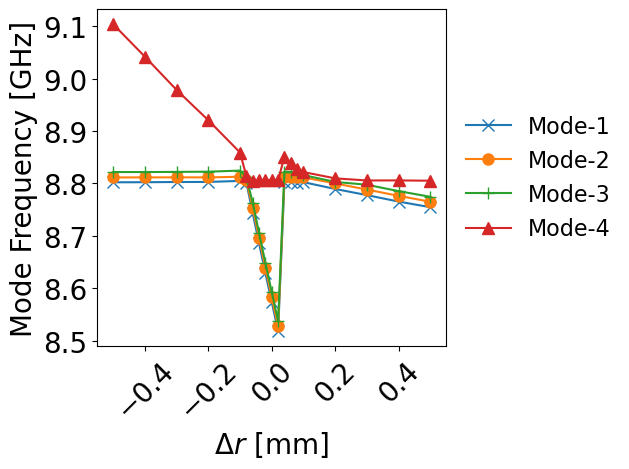

In [261]:
# Plot the modes vs. offset
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
ra0 = 15.0
M = 4
markers = ['x', 'o', '+', '^']
for m in range(1, M+1):
    # wkk, _ = mypcpl.get_w_gsms_k(m-1, units='Hz')
    ax.plot(np.asarray(Lj_vals) - ra0, wk0[m-1, m-1, :], label=f'Mode-{m}',
           marker=markers[m-1], ms=8, ls='-')
    # wkk, _ = mypcpl.get_w_gsms_k(m-1, units='Hz')
    # ax.plot(np.asarray(Lj_vals) - ra0, wkk, label=f'Mode-{m}', marker=markers[m-1], ms=10, ls='')
ax.set_xlabel(r'$\Delta r$ [mm]', fontsize=fsize)
ax.set_ylabel(r'Mode Frequency [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, 16)

In [246]:
Lj_vals.size

19

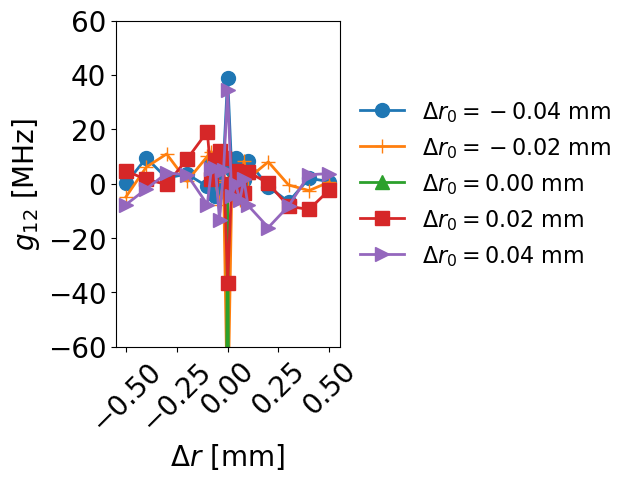

In [254]:
# Plot the modes vs. offset
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
fsize = 20
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
ra0 = 15.0
M = 2
markers = ['x', 'o', '+', '^', 's', '>']
mlen = len(markers)
zero_idx = np.asarray(np.where(np.isclose(Lj_vals, ra0))[0], dtype=np.int64)[0]
for i in [zero_idx-2, zero_idx-1, zero_idx, zero_idx+1, zero_idx+2]:
    ax.plot(np.asarray(Lj_vals) - ra0, gbs[i, :] / 1e-3,
            marker=markers[i%mlen], lw=2, ms=10, ls='-',
            label=r'$\Delta r_0 = %.2f$ mm' % (Lj_vals[i] - ra0))
ax.set_xlabel(r'$\Delta r$ [mm]', fontsize=fsize)
ax.set_ylabel(r'$g_{12}$ [MHz]', fontsize=fsize)
ax.set_ylim([-60, 60])
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
leg = set_leg_outside(ax, 16)

In [248]:
gbs, gtms = mypcpl.get_gbs_gtms_kkp(0, 1, units='Hz')

Writing ../figs/gbs_12_delta_r_delta_r0_240101.pdf ...


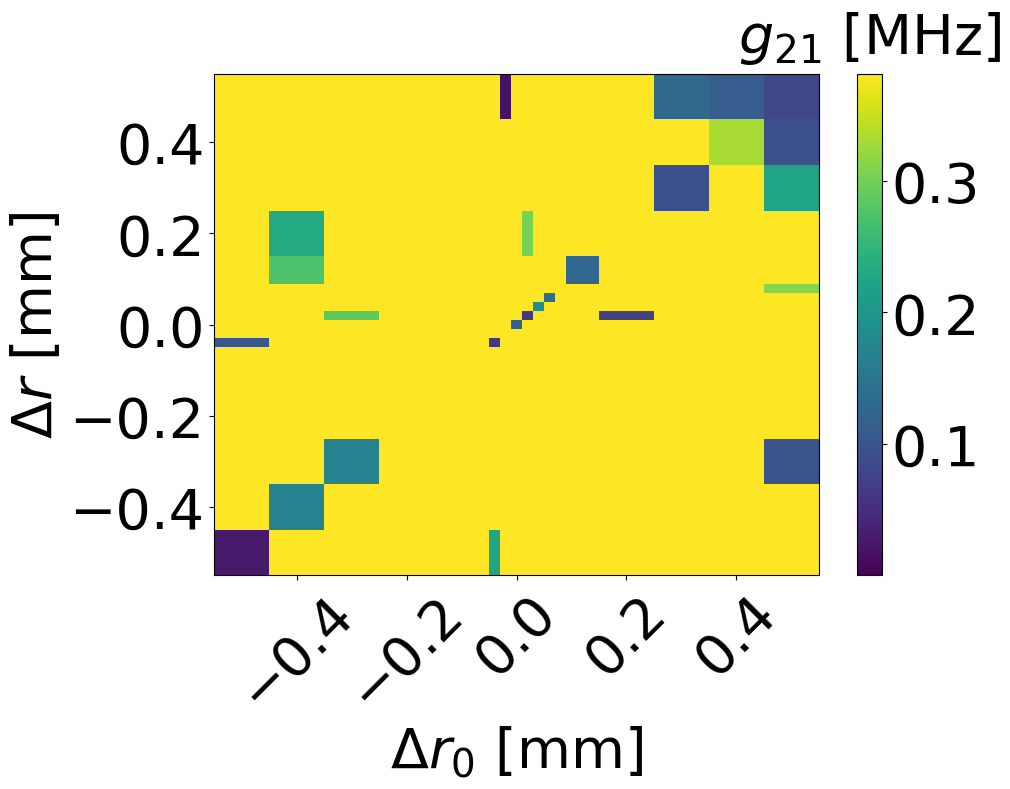

In [249]:
# Plot the Dr, Dr0 heat map
plot_2d_cmap(# LJs/1e-9,
            np.array(Lj_vals)-ra0,
            np.array(Lj_vals)-ra0,
            #wkk12,
            np.abs(gbs) / 1e-3,
            # f'../figs/w_{k1}_vs_LJLJ0_{dd}.pdf',
            f'../figs/gbs_12_delta_r_delta_r0_{dd}.pdf',
            xstr=r'$\Delta r_{0}$ [mm]',
            ystr=r'$\Delta r$ [mm]',
            tstr='',
            xyscales={'x' : 'linear', 'y' : 'linear'},
            cbar_str=r'$g_{21}$ [MHz]',
            interp_zeros=False,
            interp_std_dev=3,
            image_rot_angle=0,
            xrot_angle=45,
            norm_type='ref',
            zref=[np.abs(gbs).min(), np.abs(gbs).max()],
            fsize=40,
            tsize=46)